In [2]:
# init
import pandas as pd
import numpy as np
from tqdm import tqdm
# import nltk
# nltk.download()

Import Data

In [2]:
import glob
import os

In [ ]:
# import pubmed
pubmed = []
docList = glob.glob(os.path.join(os.getcwd(), "Datasets/pubmed/", "*.txt"))

for docPath in tqdm(docList):
    # get doc file name
    docName = os.path.basename(docPath).split('.')[0]
    className = docName[:3]
    
    with open(docPath, encoding="utf8") as doc:
        # insert [class, docs, feature]
        pubmed.append([className, docName, doc.read().replace('\n', ' ')])

# # make dataframe
# dataframe = pd.DataFrame(data=pubmed, columns=['class', 'document', 'feature']) 

# # export pubmed raw
# dataframe.to_csv('pubmed/raw.csv', index=False)

In [ ]:
# import scopus
scopus = []
docList = glob.glob(os.path.join(os.getcwd(), "Datasets/scopus/", "*"))

for docPath in tqdm(docList):
    # get doc file name
    docName = os.path.basename(docPath)
    className = docName.split('-')[0]
    
    with open(docPath, encoding="utf8") as doc:
        # insert [class, docs, feature]
        scopus.append([className, docName, doc.read().replace('\n', ' ')])

# make dataframe
dataframe = pd.DataFrame(data=scopus, columns=['class', 'document', 'feature']) 

# export pubmed raw
dataframe.to_csv('scopus/raw.csv', index=False)

Dataframe Raw

In [ ]:
# read csv
pubmedRaw = pd.read_csv('pubmed/raw.csv')
scopusRaw = pd.read_csv('scopus/raw.csv')

# get feature
pubmedFeatures = pubmedRaw.loc[:, 'feature']
scopusFeatures = scopusRaw.loc[:, 'feature']
scopusFeatures

Preprocesing

In [28]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# cleaning
def cleaning(features):
    result = []
    for feature in features:
        regex = re.sub(r'[^a-zA-Z\s]', '', feature)
        result.append(regex)
    return result

# case folding
def caseFolding(features):
    result = []
    for feature in features:
        lower = feature.lower()
        result.append(lower)
    return result

# tokenization
def tokenization(features):
    result = []
    for feature in features:
        token = word_tokenize(feature)
        result.append(token)
    return result

# stopwords removal
def stopWords(features):
    result = []
    stopWords = set(stopwords.words('english'))
    for token in features:
        cleanedFeature = [feature for feature in token if feature not in stopWords]
        result.append(cleanedFeature)
    return result

In [35]:
# preprocessing
def preprocessing(features):
    clean = cleaning(features)
    case = caseFolding(clean)
    token = tokenization(case)
    preprocessed = stopWords(token)
    return preprocessed
    
pubmedPreprocessed = preprocessing(pubmedFeatures)
scopusPreprocessed = preprocessing(scopusFeatures)
# print(scopusPreprocessed[0])

# export pubmed clean
for i in range(len(pubmedPreprocessed)):
    pubmedRaw.loc[i, 'feature'] = ' '.join(pubmedPreprocessed[i])
pubmedRaw.to_csv('pubmed/clean.csv', index=False)

# export scopus clean
for i in range(len(scopusPreprocessed)):
    scopusRaw.loc[i, 'feature'] = ' '.join(scopusPreprocessed[i])
scopusRaw.to_csv('scopus/clean.csv', index=False)

Daraframe Clean

In [ ]:
# read csv
pubmedClean = pd.read_csv('pubmed/clean.csv')
scopusClean = pd.read_csv('scopus/clean.csv')

# get feature
pubmedFeatures = pubmedClean.loc[:, 'feature']
scopusFeatures = scopusClean.loc[:, 'feature']
scopusClean

Feature Forming

In [ ]:
from textblob import TextBlob

def featureForming(features, dataframe):
    # BOAW
    dataframe.rename(columns={'feature': 'BOAW'}, inplace=True)
    for i in tqdm(range(len(features))):
        # BON
        dataframe.loc[i, 'BON'] = ' '.join(TextBlob(features[i]).noun_phrases)
        # BONA
        dataframe.loc[i, 'BONA'] = ' '.join([word for (word, tag) in TextBlob(features[i]).tags if tag[:2]=='NN' or tag[:2]=='JJ'])

featureForming(pubmedFeatures, pubmedClean)
featureForming(scopusFeatures, scopusClean)
# print(scopusClean)

pubmedClean.to_csv('pubmed/formed.csv', index=False)
scopusClean.to_csv('scopus/formed.csv', index=False)

Dataframe Formed

In [3]:
# read csv
pubmedFormed = pd.read_csv('pubmed/formed.csv')
scopusFormed = pd.read_csv('scopus/formed.csv')

# get feature
pubmedClass = pubmedFormed.loc[:, 'class']
pubmedBoaw = pubmedFormed.loc[:, 'BOAW']
pubmedBon = pubmedFormed.loc[:, 'BON']
pubmedBona = pubmedFormed.loc[:, 'BONA']

scopusClass = scopusFormed.loc[:, 'class']
scopusBoaw = scopusFormed.loc[:, 'BOAW']
scopusBon = scopusFormed.loc[:, 'BON']
scopusBona = scopusFormed.loc[:, 'BONA']
pubmedBona

0       reduced amounts immunoreactive somatostatin te...
1       diagnostic criteria primary neuronal degenerat...
2       cacetylcholine synthesis ccarbon dioxide produ...
3       pattern deterioration dementia alzheimer type ...
4       cerebral blood flow metabolic rate oxygen gluc...
                              ...                        
3995    major histocompatibility complex genes influen...
3996    hiv infection cohort haemophilic patients cour...
3997    evolution definition aids main classifications...
3998    human immunodeficiency virus glycoproteins gp ...
3999    progression aids usefulness cd lymphocyte p an...
Name: BONA, Length: 4000, dtype: object

Feature Selection

In [5]:
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import spdiags

In [28]:
# SFS
def symbolic(features, classes):
    # get tf weights
    tfVec = CountVectorizer()
    tf = tfVec.fit_transform(features)

    # define weights into dataframe
    featureName = tfVec.get_feature_names_out()
    featureWeight = tf.todense()
    df = pd.DataFrame(featureWeight, columns=featureName)
    df.loc[:, 'class'] = classes
    # return df

    # count mean & standard deviation
    mean = df.groupby('class').mean().reset_index()
    std = df.groupby('class').std().reset_index()

    totalSm = []
    for col in tqdm(mean.columns):
        if col != 'class':
            # count interval per features
            interval = []
            for row in range(len(mean)):
                meanA = mean.loc[row, col]
                stdA = std.loc[row, col]
                interval.append([meanA - stdA, meanA + stdA])
            
            # count similarity per feature
            similarity = 0
            for itvA in interval:
                # count similarity per class
                smClass = []
                for itvB in interval:
                    if itvA != itvB:
                        smClass.append((min(itvA[1], itvB[1]) - max(itvA[0], itvB[0])) / (itvB[1] - itvB[0]))

                # count total similarity
                similarity += np.nansum(smClass)
            totalSm.append(similarity)

    # count average total similarity
    avgTotalSm = np.mean(totalSm)

    # select feature that totalSm > avgTotalSm
    selected = []
    for i in range(len(totalSm)):
        if totalSm[i] > avgTotalSm:
            selected.append(df.columns[i])
    # return len(selected)
    return selected

# sfx = symbolic(pubmedBona, pubmedClass)
# print(sfx)

In [29]:
# TF-RF
def tf_rf(features, classes):
    # get tf weights
    tfVec = CountVectorizer()
    tf = tfVec.fit_transform(features)

    # get classes weights
    clsVec = LabelBinarizer()
    cls = clsVec.fit_transform(classes)
    # return cls, cls.shape

    # if has only 1 class, add negative class
    if cls.shape[1] == 1:
        cls = np.append(1 - cls, cls, axis=1)

    # count rf
    feature = ((cls.T * tf) > 0).astype(np.float64)
    # return feature.shape

    for classA in range(cls.shape[1]):
        # feature.sum(axis=0) - feature[i] is the sum of all rows except i
        feature[classA] /= np.maximum(1., feature.sum(axis=0) - feature[classA])

    rf = np.mean(np.log2(2 + feature, out=feature), axis=0)

    # count tf-rf & transform vectorizer
    n_features = rf.shape[0]
    tfRf = tf * spdiags(rf, 0, n_features, n_features)

    # define weights into dataframe
    featureName = tfVec.get_feature_names_out()
    featureWeight = tfRf.todense()
    df = pd.DataFrame(featureWeight, columns=featureName)
    df.loc[:, 'class'] = classes
    # return df

    # count weight by class
    mean = df.groupby('class').mean()
    result = (mean/mean.max()).sum()
    # return result

    # select minimum weighted features
    selected = []
    for i in tqdm(range(len(result))):
        if result[i] > np.mean(result):
            selected.append(df.columns[i])
    # return len(selected)
    return selected

# rfx = tf_rf(pubmedBona, pubmedClass)
# print(rfx)

100%|██████████| 18357/18357 [00:02<00:00, 8555.60it/s] 

['aa', 'aaf', 'ab', 'abdominal', 'aberrant', 'aberration', 'aberrations', 'abilities', 'ability', 'able', 'abnormal', 'abnormalities', 'abnormality', 'abo', 'aboriginals', 'abortion', 'abortions', 'abrogate', 'abscess', 'abscesses', 'absence', 'absent', 'absolute', 'absorbance', 'absorbed', 'absorption', 'abstraction', 'abundance', 'abundant', 'ac', 'accelerated', 'acceleration', 'acceptable', 'acceptor', 'acceptors', 'access', 'accessibility', 'accessible', 'accessory', 'accident', 'accidental', 'accidents', 'accompanies', 'accomplish', 'account', 'accounting', 'accounts', 'accumulate', 'accumulation', 'accuracy', 'accurate', 'acetate', 'acetic', 'acetone', 'acetyl', 'acetylaminofluorene', 'achievable', 'achievement', 'achlorhydria', 'acid', 'acidic', 'acidification', 'acids', 'acoustic', 'acquisition', 'acromegaly', 'acrylamide', 'act', 'acth', 'actin', 'acting', 'actinomycin', 'action', 'actions', 'activate', 'activated', 'activation', 'activator', 'active', 'activities', 'activity'

In [30]:
# Symbolic Relevance
def symbolic_relevance(features, classes):
    # get sfs
    sfs = symbolic(features, classes)
    # get tf-rf
    tfrf = tf_rf(features, classes)
    print(len(sfs), len(tfrf))

    # intersect features
    selected = list(np.intersect1d(sfs, tfrf))
    return len(selected), selected

    # update features
    token = tokenization(features)
    result = []
    for row in tqdm(token):
        words = [word for word in row if word in selected]
        result.append(words)
    return len(result), result

srx = symbolic_relevance(pubmedBona, pubmedClass)
print(srx)

  0%|          | 0/18358 [00:00<?, ?it/s]C:\Users\ZephZ\AppData\Local\Temp\ipykernel_18552\919357272.py:35: RuntimeWarning: invalid value encountered in scalar divide
  smClass.append((min(itvA[1], itvB[1]) - max(itvA[0], itvB[0])) / (itvB[1] - itvB[0]))
100%|██████████| 18357/18357 [00:01<00:00, 10032.94it/s]


4714 5645
(4329, ['aa', 'ab', 'abdominal', 'aberration', 'aberrations', 'abilities', 'ability', 'able', 'abnormal', 'abnormalities', 'abnormality', 'aboriginals', 'abortion', 'abortions', 'abrogate', 'abscess', 'abscesses', 'absence', 'absent', 'absolute', 'absorbed', 'absorption', 'abstraction', 'abundance', 'abundant', 'ac', 'accelerated', 'acceleration', 'acceptor', 'acceptors', 'access', 'accessibility', 'accessible', 'accessory', 'accident', 'accidental', 'accidents', 'accomplish', 'account', 'accounting', 'accounts', 'accumulate', 'accumulation', 'accuracy', 'accurate', 'acetate', 'acetic', 'acetone', 'acetyl', 'achievable', 'achievement', 'acid', 'acidic', 'acids', 'acoustic', 'acquisition', 'acrylamide', 'act', 'acth', 'actin', 'actinomycin', 'action', 'actions', 'activate', 'activated', 'activation', 'activator', 'active', 'activities', 'activity', 'acts', 'actual', 'acute', 'acyl', 'adaptation', 'added', 'addition', 'additional', 'additive', 'address', 'adenine', 'adenopathy'

In [11]:
# Pubmed
pubmed_boaw_sr = symbolic_relevance(pubmedBoaw, pubmedClass)
pubmed_bon_sr = symbolic_relevance(pubmedBon, pubmedClass)
pubmed_bona_sr = symbolic_relevance(pubmedBona, pubmedClass)

# Scopus
# scopus_boaw_sr = symbolic_relevance(scopusBoaw, scopusClass)
# scopus_bon_sr = symbolic_relevance(scopusBon, scopusClass)
# scopus_bona_sr = symbolic_relevance(scopusBona, scopusClass)

100%|██████████| 4000/4000 [02:32<00:00, 26.23it/s]


In [12]:
# save csv
for i in range(len(pubmedFormed)):
    # BOAW
    pubmedFormed.loc[i, 'BOAW_SR'] = ' '.join(pubmed_boaw_sr[i])
    # BON
    pubmedFormed.loc[i, 'BON_SR'] = ' '.join(pubmed_bon_sr[i])
    # BONA
    pubmedFormed.loc[i, 'BONA_SR'] = ' '.join(pubmed_bona_sr[i])

pubmedFormed.to_csv('pubmed/selected.csv', index=False)

# for i in range(len(scopusFormed)):
    # BOAW
    # scopusFormed.loc[i, 'BOAW_SR'] = ' '.join(scopus_boaw_sr[i])
    # BON
    # scopusFormed.loc[i, 'BON_SR'] = ' '.join(scopus_bon_sr[i])
    # BONA
    # scopusFormed.loc[i, 'BONA_SR'] = ' '.join(scopus_bona_sr[i])

# scopusFormed.to_csv('scopus/selected.csv', index=False)

In [14]:
# read csv
pubmedSelected = pd.read_csv('pubmed/selected.csv')
# scopusSelected = pd.read_csv('scopus/selected.csv')

# get feature
pubmedClass = pubmedSelected.loc[:, 'class']
pubmedBoaw = pubmedSelected.loc[:, 'BOAW']
pubmedBon = pubmedSelected.loc[:, 'BON']
pubmedBona = pubmedSelected.loc[:, 'BONA']
pubmedBoawSr = pubmedSelected.loc[:, 'BOAW_SR']
pubmedBonSr = pubmedSelected.loc[:, 'BON_SR']
pubmedBonaSr = pubmedSelected.loc[:, 'BONA_SR']
pubmedSelected

# scopusClass = scopusSelected.loc[:, 'class']
# scopusBoaw = scopusSelected.loc[:, 'BOAW']
# scopusBon = scopusSelected.loc[:, 'BON']
# scopusBona = scopusSelected.loc[:, 'BONA']
# scopusBoawSr = scopusSelected.loc[:, 'BOAW_SR']
# scopusBonSr = scopusSelected.loc[:, 'BON_SR']
# scopusBonaSr = scopusSelected.loc[:, 'BONA_SR']
# scopusSelected

,class,document,BOAW,BON,BONA,BONA_SR,BOAW_SR,BON_SR
0,ALZ,ALZ1,reduced amounts immunoreactive somatostatin te...,amounts immunoreactive somatostatin temporal c...,reduced amounts immunoreactive somatostatin te...,immunoreactive somatostatin senile dementia po...,immunoreactive somatostatin temporal senile de...,immunoreactive somatostatin senile dementia po...
1,ALZ,ALZ10,diagnostic criteria primary neuronal degenerat...,diagnostic criteria primary neuronal degenerat...,diagnostic criteria primary neuronal degenerat...,diagnostic primary degeneration alzheimers att...,diagnostic primary degeneration alzheimers att...,diagnostic primary degeneration alzheimers att...
2,ALZ,ALZ100,cacetylcholine synthesis ccarbon dioxide produ...,cacetylcholine synthesis ccarbon dioxide produ...,cacetylcholine synthesis ccarbon dioxide produ...,cacetylcholine synthesis ccarbon prisms human ...,cacetylcholine ccarbon prisms human neocortex ...,cacetylcholine ccarbon prisms human neocortex ...
3,ALZ,ALZ1000,pattern reading deterioration dementia alzheim...,pattern reading deterioration dementia alzheim...,pattern deterioration dementia alzheimer type ...,deterioration dementia observations implicatio...,deterioration dementia implications dementia t...,deterioration dementia implications dementia d...
4,ALZ,ALZ101,cerebral blood flow metabolic rate oxygen gluc...,cerebral blood flow metabolic rate oxygen gluc...,cerebral blood flow metabolic rate oxygen gluc...,flow metabolic oxygen glucose lactate pyruvate...,flow metabolic oxygen glucose lactate pyruvate...,flow metabolic oxygen glucose lactate pyruvate...
...,...,...,...,...,...,...,...,...
3995,HIV,HIV3996,major histocompatibility complex genes influen...,major histocompatibility complex genes outcome...,major histocompatibility complex genes influen...,histocompatibility hiv infection ancestral hap...,histocompatibility hiv infection ancestral hap...,histocompatibility hiv infection ancestral hap...
3996,HIV,HIV3997,hiv infection cohort haemophilic patients cour...,hiv infection cohort haemophilic patients cour...,hiv infection cohort haemophilic patients cour...,hiv infection haemophilic hiv infection haemop...,hiv infection haemophilic course hiv infection...,hiv infection haemophilic hiv infection haemop...
3997,HIV,HIV3998,evolution definition aids main classifications...,evolution definition aids main classifications...,evolution definition aids main classifications...,evolution aids infection evolution aids hiv in...,evolution aids hiv infection evolution aids hi...,evolution aids classifications hiv infection e...
3998,HIV,HIV3999,human immunodeficiency virus glycoproteins gp ...,human immunodeficiency virus glycoproteins gp ...,human immunodeficiency virus glycoproteins gp ...,human immunodeficiency glycoproteins gp cdt re...,human immunodeficiency glycoproteins gp gp spe...,human glycoproteins gp gp cdt receptor phospho...


Term Weighting

In [4]:
# TF
def tf(features):
    # get tf weights
    tfVec = CountVectorizer()
    result = tfVec.fit_transform(features)

    # define weights into dataframe
    featureName = tfVec.get_feature_names_out()
    featureWeight = result.todense()
    df = pd.DataFrame(featureWeight, columns=featureName)
    return df

    # # counting weights into dictionary
    # tf = dict.fromkeys(featureName, 0)
    # for word in tqdm(featureName):
    #     arr = np.array(df.loc[:, word])
    #     val = np.sum(arr)
    #     tf[word] = val
    # return tf

# tfx = tf(bona)
# print(tfx)

# TF-IDF
def tf_idf(features):
    # get tf-idf weights
    tfIdfVec = TfidfVectorizer()
    result = tfIdfVec.fit_transform(features)

    # define weights into dataframe
    featureName = tfIdfVec.get_feature_names_out()
    featureWeight = result.todense()
    df = pd.DataFrame(featureWeight, columns=featureName)
    return df
    
    # # counting weights into dictionary
    # tfIdf = dict.fromkeys(featureName, 0)
    # for word in tqdm(featureName):
    #     arr = np.array(df.loc[:, word])
    #     val = np.sum(arr)
    #     tfIdf[word] = val
    # return tfIdf

# idfx = tf_idf(bona)
# print(idfx)

# TF-IDF-ICF
def icf(word, features, classes):
    classTotal = []
    classTerm = []

    for i in range(len(classes)):
        # count class 
        if classes[i] not in classTotal:
            classTotal.append(i)

            # count class term
            if word in features[i]:
                if classes[i] not in classTerm:
                    classTerm.append(classes[i])
  
    # count icf
    icf = 1 + math.log(len(classTotal) / float(len(classTerm)))
    return icf

def tf_idf_icf(features, classes):
    # count tf-idf
    df = tf_idf(features)

    for col in tqdm(df.columns):
        icfResult = icf(col, features, classes)
        for row in range(len(features)):
            df.loc[row, col] = df.loc[row, col] * icfResult
    return df

    # # counting weights into dictionary
    # tfIdfIcf = dict.fromkeys(list(tfIdf.keys()), 0)
    # for word, val in tqdm(tfIdf.items()):
    #     tfIdfIcf[word] = val * icf(word, features)
    # return tfIdfIcf

# icfx = tf_idf_icf(bona, classes)
# print(icfx)

In [9]:
# BONA > SR > TF-IDF
bona_sr_tfidf = tf_idf(bona_sr)
bona_sr_tfidf

,aab,aabc,aac,aagarose,abbott,abbreviation,abc,abdomen,abdominoperineal,abe,...,zoster,zovirax,zucker,zurich,zygomycete,zygomycetes,zygomycosis,zygotic,zymosan,zypab
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# save csv
bona_sr_tfidf.to_csv('pubmed/bona_sr_tfidf.csv', index=False)

In [2]:
# read csv
bona_sr_tfidf = pd.read_csv('pubmed/bona_sr_tfidf.csv')
bona_sr_tfidf

,aab,aabc,aac,aagarose,abbott,abbreviation,abc,abdomen,abdominoperineal,abe,...,zoster,zovirax,zucker,zurich,zygomycete,zygomycetes,zygomycosis,zygotic,zymosan,zypab
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Clustering

In [5]:
from sklearn.cluster import KMeans
# from spherecluster import SphericalKMeans
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
# Decompose data
def decompose(n, data):
    # decompose
    pcaVec = PCA(n_components=n, random_state=42)
    pca = pcaVec.fit_transform(data)
    return pca

# K-Means++
def kmeansPlus(n, data):
    # clustering
    kmp = KMeans(n_clusters=n, init = 'k-means++')
    kmp.fit(data)
    predict = kmp.predict(data)
    label = kmp.labels_

    # plot scatter
    plt.scatter(data[:, 0], data[:, 1])
    plt.scatter(data[:, 0], data[:, 1], c = label)
    return predict

# kmpx = kmeansPlus(3, bona_sr_tfidf)
# print(kmpx)

# Spherical K-Means
# def spherKmeans(n, data):
#     # clustering
#     skm = SphericalKMeans(n_clusters=n)
#     skm.fit(data)
#     predict = skm.predict(data)
#     label = skm.labels_

#     # plot scatter
#     plt.scatter(data[:, 0], data[:, 1])
#     plt.scatter(data[:, 0], data[:, 1], c = label)
#     return predict

# skmx = spherKmeans(3, bona_sr_tfidf)
# print(skmx)

Performance Analysis

C:\Users\ZephZ\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


silhouette 0.513148817577518


C:\Users\ZephZ\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(4000, 4)
(4000,)
purity None


C:\Users\ZephZ\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: labels_true must be 1D: shape is (4000, 4)

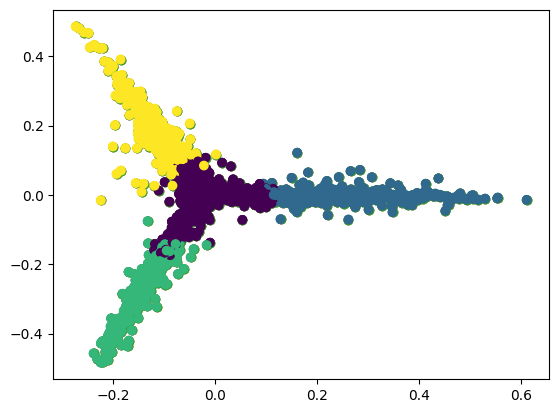

In [10]:
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_mutual_info_score

# Silhouette Score
def silhouette(cluster, n, data):
    true = decompose(n, data)

    if (cluster == 'kmp'):
        pred = kmeansPlus(n, true)
    # elif (cluster == 'skm'):
    #     pred = spherKmeans(n, true)

    silhouetteScore = silhouette_score(true, pred)
    return silhouetteScore

sx = silhouette('kmp', 4, bona_sr_tfidf)
print('silhouette', sx)

# Purity
def purity(cluster, n, data):
    true = decompose(n, data)

    if (cluster == 'kmp'):
        pred = kmeansPlus(n, true)
    # elif (cluster == 'skm'):
    #     pred = spherKmeans(n, true)

    contingencyMatrix = contingency_matrix(true, pred)
    purityScore = np.sum(np.amax(contingencyMatrix, axis=0)) / np.sum(contingencyMatrix)
    return purityScore

px = purity('kmp', 4, bona_sr_tfidf)
print('purity', px)

# AMI
def ami(cluster, n, data):
    true = decompose(n, data)

    if (cluster == 'kmp'):
        pred = kmeansPlus(n, true)
    # elif (cluster == 'skm'):
    #     pred = spherKmeans(n, true)

    amiScore = adjusted_mutual_info_score(true, pred)
    return amiScore

ax = ami('kmp', 4, bona_sr_tfidf)
print('ami', ax)